In [2]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 381 kB 20.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 한국어 w2v (네이버 영화리뷰)

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fc1860a0970>)

In [6]:
# 데이터프레임으로 로드
train_data = pd.read_table('ratings.txt')

train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [7]:
print(len(train_data)) # 총 리뷰갯수

200000


In [8]:
# df 결측값 유무 확인 NULL 값

print(train_data.isnull().values.any())

True


In [9]:
train_data = train_data.dropna(how = 'any') # null값 존재하는 행 제거
print(train_data.isnull().values.any())

False


In [10]:
print(len(train_data))

199992


In [11]:
# regex, 한글외 문자 제거 (숫자포함)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-11-e1e97cc3f14d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [12]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [15]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [18]:
import time
from tqdm import tqdm

start_time = time.time()

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


end_time = time.time()
print('total time: ', end_time - start_time)

100%|██████████| 199992/199992 [08:18<00:00, 401.50it/s]

total time:  498.1770067214966


In [21]:
print(tokenized_data[:5])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다'], ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고'], ['오다', '연기', '진짜', '개', '쩔다', '지루하다', '생각', '몰입', '보다', '그렇다', '이렇다', '진짜', '영화', '지'], ['안개', '자욱하다', '밤하늘', '뜨다', '있다', '초승달', '같다', '영화']]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


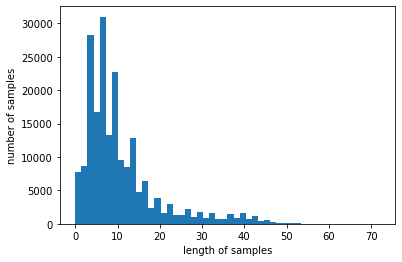

In [25]:
# 토큰화 상태 -> 각 리뷰 길이 분포 확인 가능

# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# w2v으로 토큰화 된 네이버 영화리뷰 데이터 학습

from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 50, min_count = 5, workers = 4, sg = 0)

In [33]:
# 완성된 w2v 임베딩 행렬크기 확인
model.wv.vectors.shape

(16477, 100)

In [34]:
print(model.wv.most_similar('최민식'))

[('한석규', 0.8259876370429993), ('안성기', 0.7879250645637512), ('홍금보', 0.7594034075737), ('홍경인', 0.7497853636741638), ('양동근', 0.7489628791809082), ('마스터', 0.7462535500526428), ('미남', 0.7437652945518494), ('주진모', 0.7428683042526245), ('김성수', 0.7355199456214905), ('존슨', 0.734558641910553)]


In [35]:
print(model.wv.most_similar('히어로'))

[('호러', 0.8184073567390442), ('물', 0.8152245283126831), ('슬래셔', 0.8086352944374084), ('블록버스터', 0.8006179928779602), ('느와르', 0.7916381359100342), ('무비', 0.76705002784729), ('첩보', 0.7628342509269714), ('판타지', 0.7600809335708618), ('물의', 0.7591420412063599), ('무협', 0.7570978403091431)]


### 사전훈련된 word2vec 임베딩 (pre-trained word2vec embedding)

가지고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만,
위키피디아 등 방대한 데이터로 사전에 훈련된 워드 임베딩 (pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 가능

e.g., analyse de sentiment
-> 훈련 데이터 양 부족? -> 다른 방대한 데이터를 w2v 이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고와서 모델의 입력으로 사용하는것이 때로는 더 좋은 성능 얻음.

구글이 제공하는 사전훈련된 w2v 모델 사용:
-3백만개 w2v 단어 벡터들 제공
-vector_size = 300 (embedding vec dim)
-gensim통해 모델 불러옴 (간단)

In [36]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True) # 압축풀기

In [40]:
print(word2vec_model.vectors.shape) # 모델 크기 확인; 행:단어수, 열(차원수): 차원
# 파일크기 계산 = 3 milion words * 300 features * 4bytes/feature = ~3.35GB

(3000000, 300)


In [42]:
# 사전훈련 임베딩 사용해, 두 단어의 유사도 계산 (w1,w2)

print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))
print(word2vec_model.similarity('i', 'ice'))

0.40797037
0.057204384
0.014778547


In [43]:
# 단어 'book'의 벡터 출력
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

In [44]:
print(len(word2vec_model['book'])) #총 피쳐 300

300
